In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import  lightgbm as lgb
from catboost import CatBoostClassifier,Pool
from catboost.utils import eval_metric

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_submission=pd.read_csv('sample_submission.csv')
df_test=pd.read_csv('test.csv')
df_train=pd.read_csv('train.csv')

In [3]:
df_test_ov=df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [4]:
pd.set_option('display.max_columns',None)

In [5]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [7]:
df_submission.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [8]:
num_train_rows,num_train_columns=df_train.shape
num_test_rows,num_test_columns=df_test.shape
num_submission_rows,num_submission_columns=df_submission.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Submission Data:")
print(f"Number of Rows: {num_submission_rows}")
print(f"Number of Columns: {num_submission_columns}")

Training Data:
Number of Rows: 165034
Number of Columns: 14

Test Data:
Number of Rows: 110023
Number of Columns: 13

Submission Data:
Number of Rows: 110023
Number of Columns: 2


In [9]:
train_null=df_train.isnull().sum().sum()
test_null=df_test.isnull().sum().sum()
submission_null=df_submission.isnull().sum().sum()
print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test: {test_null}')
print(f'Null Count in Submission: {submission_null}')

Null Count in Train: 0
Null Count in Test: 0
Null Count in Submission: 0


In [10]:
train_duplicates=df_train.duplicated().sum()
test_duplicates=df_test.duplicated().sum()
submission_duplicates=df_submission.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in test_data: {submission_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in test_data: 0


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [12]:
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [13]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

# palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

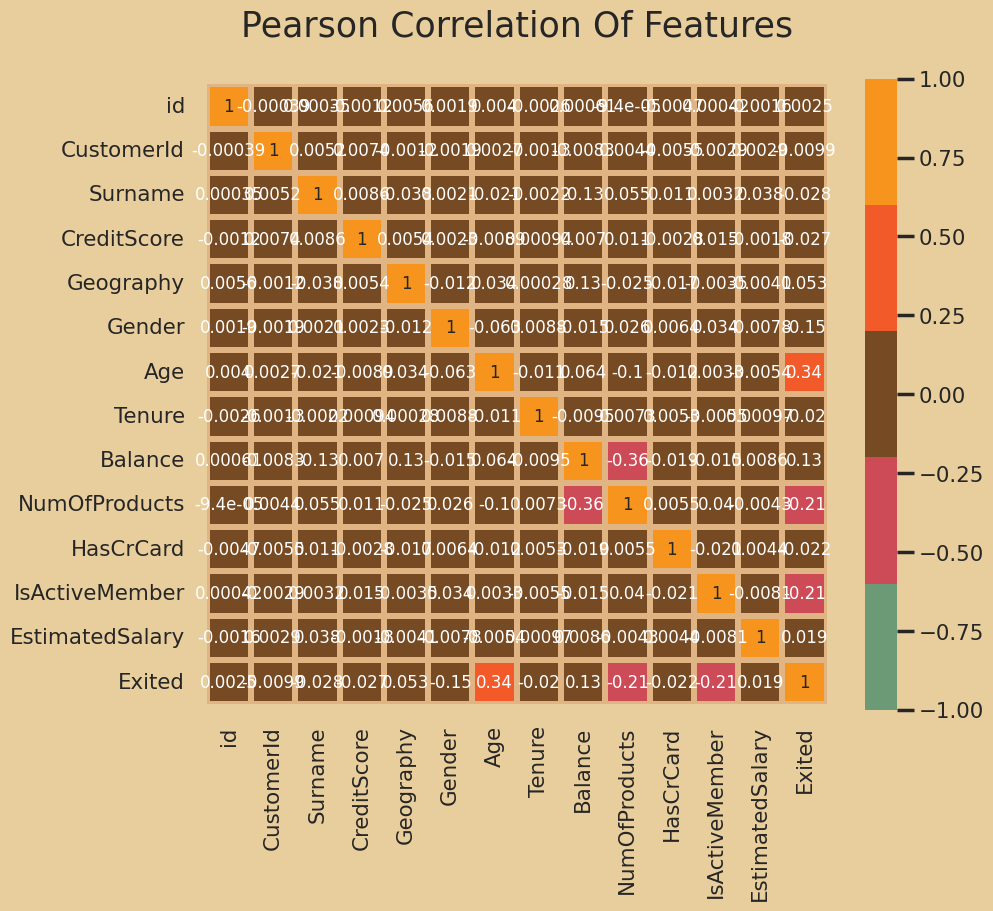

In [14]:
df_corr = df_train.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        df_corr[col] = le.fit_transform(df_corr[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(df_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =12))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

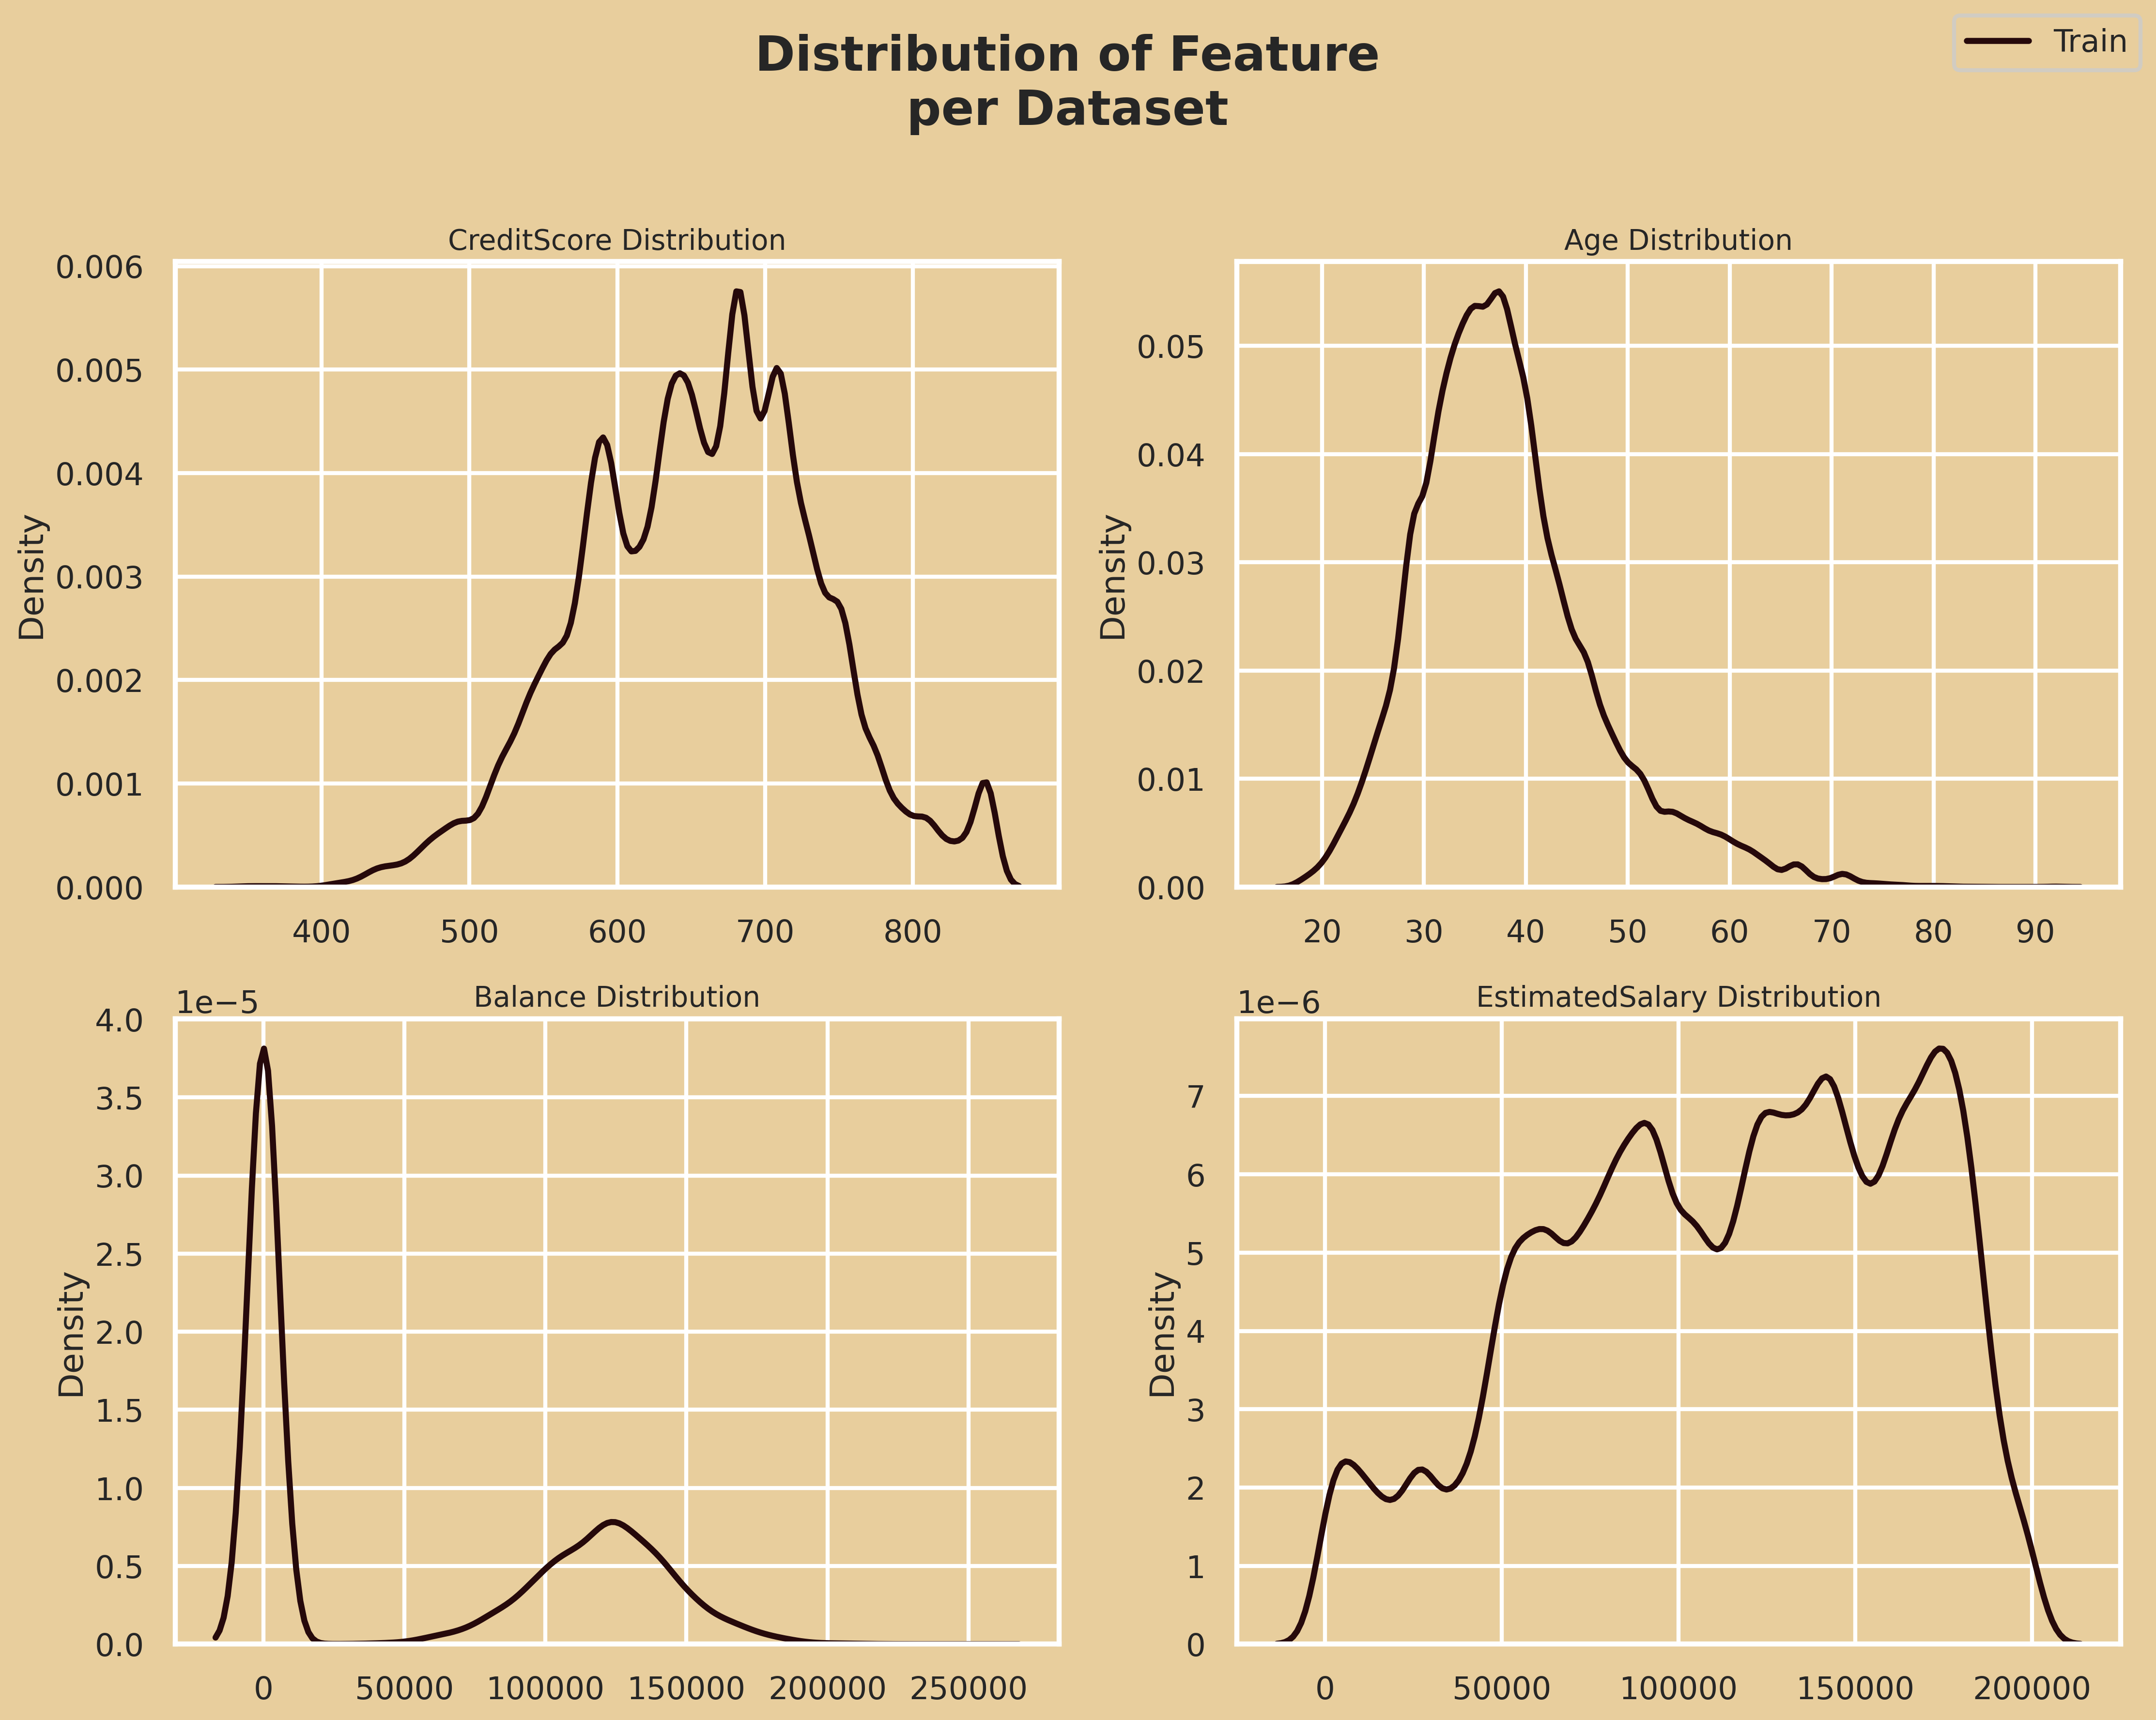

In [15]:
fig, ax = plt.subplots(2, 2, figsize = (15, 12), dpi = 300)
ax = ax.flatten()

numerical_variables = ['CreditScore','Age', 'Balance','EstimatedSalary' ]
for i, column in enumerate(numerical_variables):
    sns.kdeplot(df_train[column], ax=ax[i], palette=palette[0:2], color = '#26090b')        
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train'])
plt.tight_layout()

In [16]:
numeirc_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
#Use Loop Function
for col in numeirc_cols:
    sc = MinMaxScaler()
    df_train[col+"_scaled"] = sc.fit_transform(df_train[[col]])
    df_test[col+"_scaled"] = sc.fit_transform(df_test[[col]])

In [17]:
df_train['Sur_Geo_Gend_Sal'] = df_train['CustomerId'].astype('str')+df_train['Surname']+df_train['Geography']+df_train['Gender']+np.round(df_train.EstimatedSalary).astype('str')
df_test['Sur_Geo_Gend_Sal'] = df_test['CustomerId'].astype('str')+df_test['Surname']+df_test['Geography']+df_test['Gender']+np.round(df_test.EstimatedSalary).astype('str')

In [18]:
def get_vectors(df_train,df_test,col_name):

    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(3)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test

In [19]:
df_train,df_test = get_vectors(df_train,df_test,'Surname')
df_train,df_test = get_vectors(df_train,df_test,'Sur_Geo_Gend_Sal')

In [20]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.202703,0.636,0.000000,0.907279,15674932OkwudilichukwuFranceMale181450.0,-4.053118e-08,-9.086222e-07,-6.689771e-07,0.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.202703,0.554,0.000000,0.247483,15749177OkwudiliolisaFranceMale49504.0,3.596873e-07,1.995924e-06,3.151054e-07,0.0,0.0,0.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.297297,0.656,0.000000,0.924364,15694510HsuehFranceMale184867.0,-3.335032e-03,-1.905899e-02,-8.109838e-03,0.0,0.0,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.216216,0.462,0.593398,0.422787,15741417KaoFranceMale84561.0,1.650461e-03,7.565209e-03,3.764763e-03,0.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.202703,0.732,0.000000,0.075293,15766172ChiemenamSpainMale15069.0,2.968261e-07,5.812740e-07,1.072140e-06,0.0,0.0,0.0


In [21]:
def feature_data(df):
    
    df['Senior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    
    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    #onehotEncoding
    df=pd.get_dummies(df,columns=cat_cols)
    return df

In [22]:
#Genrating New Features
df_train = feature_data(df_train)
df_test = feature_data(df_test)

##Selecting Columns FOr use 
feat_cols=df_train.columns.drop(['id', 'CustomerId', 'Surname','Exited','Sur_Geo_Gend_Sal'])
feat_cols=feat_cols.drop(numeirc_cols)

#Printing
print(feat_cols)
df_train.head()

Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Sur_Geo_Gend_Sal_tfidf_0', 'Sur_Geo_Gend_Sal_tfidf_1',
       'Sur_Geo_Gend_Sal_tfidf_2', 'Senior', 'Active_by_CreditCard',
       'Products_Per_Tenure', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'AgeCat_1',
       'AgeCat_2', 'AgeCat_3', 'AgeCat_4', 'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2,Senior,Active_by_CreditCard,Products_Per_Tenure,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,0,0.202703,0.636,0.000000,0.907279,15674932OkwudilichukwuFranceMale181450.0,-4.053118e-08,-9.086222e-07,-6.689771e-07,0.0,0.0,0.0,0,0.0,1.5,True,False,False,False,True,False,True,False,False,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,0,0.202703,0.554,0.000000,0.247483,15749177OkwudiliolisaFranceMale49504.0,3.596873e-07,1.995924e-06,3.151054e-07,0.0,0.0,0.0,0,1.0,0.5,True,False,False,False,True,False,True,False,False,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,0,0.297297,0.656,0.000000,0.924364,15694510HsuehFranceMale184867.0,-3.335032e-03,-1.905899e-02,-8.109838e-03,0.0,0.0,0.0,0,0.0,5.0,True,False,False,False,True,False,True,False,False,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,0,0.216216,0.462,0.593398,0.422787,15741417KaoFranceMale84561.0,1.650461e-03,7.565209e-03,3.764763e-03,0.0,0.0,0.0,0,1.0,2.0,True,False,False,False,True,True,False,False,False,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,0,0.202703,0.732,0.000000,0.075293,15766172ChiemenamSpainMale15069.0,2.968261e-07,5.812740e-07,1.072140e-06,0.0,0.0,0.0,0,1.0,2.5,False,False,True,False,True,False,True,False,False,False,True,False,False,False


In [23]:
X=df_train[feat_cols]
y=df_train['Exited']

In [24]:
X.head()

,Tenure,HasCrCard,IsActiveMember,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2,Senior,Active_by_CreditCard,Products_Per_Tenure,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,3,1.0,0.0,0.202703,0.636,0.000000,0.907279,-4.053118e-08,-9.086222e-07,-6.689771e-07,0.0,0.0,0.0,0,0.0,1.5,True,False,False,False,True,False,True,False,False,False,True,False,False,False
1,1,1.0,1.0,0.202703,0.554,0.000000,0.247483,3.596873e-07,1.995924e-06,3.151054e-07,0.0,0.0,0.0,0,1.0,0.5,True,False,False,False,True,False,True,False,False,False,True,False,False,False
2,10,1.0,0.0,0.297297,0.656,0.000000,0.924364,-3.335032e-03,-1.905899e-02,-8.109838e-03,0.0,0.0,0.0,0,0.0,5.0,True,False,False,False,True,False,True,False,False,False,True,False,False,False
3,2,1.0,1.0,0.216216,0.462,0.593398,0.422787,1.650461e-03,7.565209e-03,3.764763e-03,0.0,0.0,0.0,0,1.0,2.0,True,False,False,False,True,True,False,False,False,False,True,False,False,False
4,5,1.0,1.0,0.202703,0.732,0.000000,0.075293,2.968261e-07,5.812740e-07,1.072140e-06,0.0,0.0,0.0,0,1.0,2.5,False,False,True,False,True,False,True,False,False,False,True,False,False,False


In [25]:
print(f'The Shape Of X is {X.shape}')

The Shape Of X is (165034, 30)


In [26]:
lgbParams = {'n_estimators': 1000,
             'max_depth': 25, 
             'learning_rate': 0.025,
             'min_child_weight': 3.43,
             'min_child_samples': 216, 
             'subsample': 0.782,
             'subsample_freq': 4, 
             'colsample_bytree': 0.29, 
             'num_leaves': 21}

[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2406
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


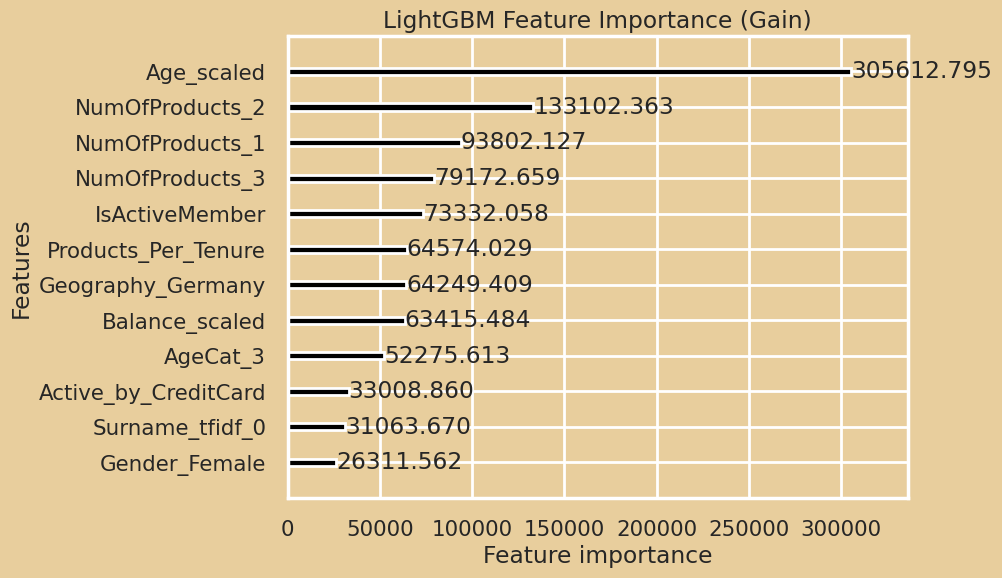

In [27]:
lgb_model=lgb.LGBMClassifier(**lgbParams)
lgb_model.fit(X,y)
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(8,6), max_num_features=12, color = "black",
                    title="LightGBM Feature Importance (Gain)")
plt.show()

In [29]:
# Features to use
feat_cols = X.columns

#Intilize folds 
n = 10

# Initialize StratifiedKFold
folds = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)
test_preds = np.empty((n, len(df_test)))
auc_vals = []

# Loop through folds 
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    ''' in each iteration of the cross-validation loop, the model is trained on a specific subset 
    of the data (training set) and validated on a different subset (validation set), facilitating the evaluation of the model's performance 
    across diverse portions of the dataset.'''
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[valid_idx], y.iloc[valid_idx]
    
    #LGB Classifier
    lgb_model = lgb.LGBMClassifier(**lgbParams)
    
    #Fitting the model
    lgb_model.fit(X_train_fold, y_train_fold,
            eval_set=[(X_test_fold, y_test_fold)],
            eval_metric='auc')
    
    #Predicting on validation set and Printing Results.
    y_pred_val = lgb_model.predict_proba(X_test_fold[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_test_fold, y_pred_val)
    print(f"AUC for fold {n_fold}: {auc_val}")
    auc_vals.append(auc_val)
    
    y_pred_test_light = lgb_model.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test_light
    print("---------Fold Completed--------")
print('\n **** Loop finished Successfully **** ')

[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC for fold 0: 0.8958779546697402
---------Fold Completed--------
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [30]:
mean_auc_light = np.mean(auc_vals)
print(f"\nMean AUC Of LightGBM : {mean_auc_light}")


Mean AUC Of LightGBM : 0.8940703918738405


In [31]:
y_pred_light = test_preds.mean(axis=0)

In [32]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({'id': df_test['id'], 'Exited': y_pred_light})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_act_1.csv', index=False)
# 
print("Submission file created successfully!")

Submission file created successfully!


In [33]:
# Features to use
feat_cols = X.columns

#Intilize folds 
n = 5

#Cat_features
cat_features = np.where(X.dtypes != np.float64)[0]

# Initialize StratifiedKFold
folds = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)
test_preds = np.empty((n, len(df_test)))
auc_vals_cat = []

# Loop through folds 
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    ''' in each iteration of the cross-validation loop, the model is trained on a specific subset 
    of the data (training set) and validated on a different subset (validation set), facilitating the evaluation of the model's performance 
    across diverse portions of the dataset.'''
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train_fold, y_train_fold,cat_features=cat_features)
    val_pool = Pool(X_test_fold, y_test_fold,cat_features=cat_features)
    
    cat_model = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.022,
    iterations=1000)
    cat_model.fit(train_pool, eval_set=val_pool,verbose=False)
    
    #Predicting Prohabilites 
    y_pred_val_cat = cat_model.predict_proba(X_test_fold[feat_cols])[:,1]
    auc_val = roc_auc_score(y_test_fold, y_pred_val_cat)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals_cat.append(auc_vals)
    
    y_pred_test_cat = cat_model.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test_cat
    print(f"------- Loop Completed for Fold {n_fold} --------")

AUC for fold  0 :  0.8926847286471713
------- Loop Completed for Fold 0 --------
AUC for fold  1 :  0.892422462304141
------- Loop Completed for Fold 1 --------
AUC for fold  2 :  0.8942137394187246
------- Loop Completed for Fold 2 --------
AUC for fold  3 :  0.8937200184173217
------- Loop Completed for Fold 3 --------
AUC for fold  4 :  0.8908397394908512
------- Loop Completed for Fold 4 --------


In [34]:
mean_auc_cat = np.mean(auc_vals_cat)
print(f"\nMean AUC Of CatBoost : {mean_auc_cat}")


Mean AUC Of CatBoost : 0.8940703918738403


In [35]:
y_pred_cat = test_preds.mean(axis=0)

In [36]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({'id': df_test['id'], 'Exited': y_pred_cat})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_act_2.csv', index=False)
# 
print("Submission file created successfully!")

Submission file created successfully!
